### Privacy preserving logistic regression
#### A post-processing example

In this notebook we give examples of performing more complicated analyses, such as regression, as [post-processing] on data which has already had noise infused.

Several common formally private noise injection methods depend upon the concept of global sensitivity: how much can a given output change due to adding or deleting a single person across all possible datasets we could observe.

Regression poses a problem for these methods. If we consider a simple ordinary least squares model with a single predictor, we can imagine scenarios where adding or deleting a single person can have a marked effect upon the slope of the regression line:
[Illustration here]


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests, zipfile, io
import sklearn
import random
from typing import Union
import statsmodels.api as sm

## Logistic Regression as Post-Processing

In [2]:
if 'z' not in locals():
    r = requests.get('https://www2.census.gov/programs-surveys/acs/data/pums/2017/5-Year/csv_pla.zip')
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extract('psam_p22.csv')

keepcols = ['PUMA','RACWHT','PINCP','AGEP','SCHL','MIGPUMA','MIGSP']
pa = pd.read_csv("psam_p22.csv", usecols=keepcols)

In [3]:
#getting data
pa.query('PUMA==2400', inplace=True)

In [4]:
def migrecode(migpuma):
    if pd.isnull(migpuma):
        return 0
    else:
        return 1
    
def agerecode(age):
    if age < 18:
        return 0
    else:
        return 1

def schlrecode(schl):
    if schl < 18:
        return 0
    else:
        return 1

pa['MIGRATED']=pa.MIGPUMA.apply(migrecode)
pa['ADULT']=pa.AGEP.apply(agerecode)
pa['COLLEGE']=pa.SCHL.apply(schlrecode)
print(pa.head())
print(pa.ADULT.value_counts())

     PUMA  AGEP  SCHL  MIGPUMA  MIGSP    PINCP  RACWHT  MIGRATED  ADULT  \
207  2400    30  18.0   2390.0   22.0  35000.0       0         1      1   
208  2400     7   4.0      NaN    NaN      NaN       0         0      0   
275  2400    56  22.0      NaN    NaN  68000.0       0         0      1   
276  2400    57  20.0      NaN    NaN  58700.0       0         0      1   
382  2400    26  12.0      NaN    NaN  18000.0       1         0      1   

     COLLEGE  
207        1  
208        0  
275        1  
276        1  
382        0  
1    6807
0    1801
Name: ADULT, dtype: int64


In [5]:
#feature selection 
#TODO: change Y value to rent or mortage
X = pa[['RACWHT','ADULT','COLLEGE']]
y = pa.MIGRATED

logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.416755
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.194   
Dependent Variable: MIGRATED         AIC:              7180.8469
Date:               2019-08-16 14:40 BIC:              7202.0282
No. Observations:   8608             Log-Likelihood:   -3587.4  
Df Model:           2                LL-Null:          -3003.9  
Df Residuals:       8605             LLR p-value:      1.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     6.0000                                      
-----------------------------------------------------------------
             Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-----------------------------------------------------------------
RACWHT      -0.3559    0.0653   -5.4504  0.0000  -0.4839  -0.2279
ADULT       -1.8148    0.0549  -33.0535  0.0000  -1.9224  -1.7072
COLLEGE 

## Laplace Noise

In [6]:
def laplace_mech(mu: Union[float, np.ndarray], epsilon: int, sensitivity: float = 1.0):
    """
    Implementation of the Laplace Mechanism

    Args:
      mu (float or numpy array): the true answer
      epsilon (int): the privacy budget
      sensitivity (float): the global sensitivity of the query
    """
    eps = epsilon/float(sensitivity)
    scale = 1/eps
    np_shape = np.shape(mu)
    shape = None if np_shape == () else np_shape
    z = np.random.laplace(0.0, scale=scale, size=shape)
    return mu + z

In [7]:
tab=pd.crosstab(pa.MIGRATED, [pa.RACWHT, pa.ADULT, pa.COLLEGE])
#tab=pd.crosstab(pa.MIGRATED, [pa.RACWHT, pa.ADULT, pa.COLLEGE]).unstack()
noise = laplace_mech(np.zeros(tab.shape), 0.1, 1.0)
noisy_tab = tab + noise
print(tab.unstack())
print(noisy_tab.unstack())

RACWHT  ADULT  COLLEGE  MIGRATED
0       0      0        0            984
                        1            125
               1        0            161
                        1             23
        1      0        0           1806
                        1            193
               1        0           2296
                        1            220
1       0      0        0            358
                        1             37
               1        0             95
                        1             18
        1      0        0            348
                        1             49
               1        0           1603
                        1            292
dtype: int64
RACWHT  ADULT  COLLEGE  MIGRATED
0       0      0        0            995.263789
                        1            139.737473
               1        0            188.781115
                        1             28.333794
        1      0        0           1814.042436
                        1

In [8]:
def avg_l1_laplace(epsilon, mu, sensitivity=1.0, n=1000):
    """Takes the average error of the laplace mechanism on an array over n samples.
  　
    Args:
      epsilon (int): the privacy budget
      mu (float or numpy array): the true answer
      n (int): number of samples
    """
    total = 0
    for i in range(n):
        noisy_arr = laplace_mech(mu, epsilon)
        accuracy = 1 - (np.linalg.norm(noisy_arr-mu, 1)/(2*mu.sum()))
        total += accuracy
    return total/n


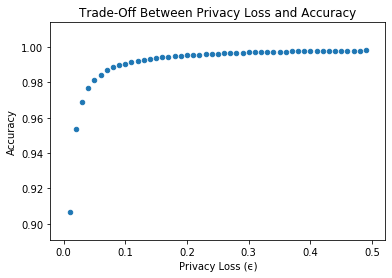

In [9]:
orig_arr = tab.unstack().values
accuracy_df = pd.DataFrame()
eps_range = np.arange(0.01,0.5,0.01)
accuracy_df['Privacy Loss (ϵ)'] = eps_range
#print(avg_l1_laplace(1, orig_arr))

accuracy_df['Accuracy'] = [avg_l1_laplace(x, orig_arr) for x in eps_range]
accuracy_df.plot.scatter('Privacy Loss (ϵ)', 'Accuracy')
plt.title('Trade-Off Between Privacy Loss and Accuracy')
plt.style.use('seaborn-paper')
plt.savefig('out/fig.png',facecolor='w', edgecolor='w',
        orientation='portrait', ransparent=False, bbox_inches=None, pad_inches=0.1)
plt.show()

In [10]:
def post_process(tab_values: np.array):
    tab_values[tab_values < 0] = 0
    return tab_values.round().astype('int')

def reconstruct(noisy_tab):
    noisy_unstack = noisy_tab.unstack()
    reps = post_process(noisy_unstack.values)
    colnames = noisy_unstack.index.names
    combinations = noisy_unstack.index.get_values()
    combinations = np.matrix([list(tup) for tup in combinations])
    noisy_microdata = pd.DataFrame(np.repeat(combinations, reps, axis=0),
                                  columns=colnames)
    return noisy_microdata

noisy_microdata = reconstruct(noisy_tab)
print(noisy_microdata.ADULT.value_counts())


1    6783
0    1884
Name: ADULT, dtype: int64


In [11]:
X = noisy_microdata[['RACWHT','ADULT','COLLEGE']]
y = noisy_microdata.MIGRATED

logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.417933
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.175   
Dependent Variable: MIGRATED         AIC:              7250.4586
Date:               2019-08-16 14:40 BIC:              7271.6604
No. Observations:   8667             Log-Likelihood:   -3622.2  
Df Model:           2                LL-Null:          -3083.1  
Df Residuals:       8664             LLR p-value:      1.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     6.0000                                      
-----------------------------------------------------------------
             Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-----------------------------------------------------------------
RACWHT      -0.3236    0.0652   -4.9631  0.0000  -0.4514  -0.1958
ADULT       -1.8294    0.0542  -33.7530  0.0000  -1.9356  -1.7231
COLLEGE 